# Action Detection For Sign Language

###### Required Dependencies

In [6]:
#syntax for installing dependencies
#!pip install tensorflow opencv-python mediapipe sklearn matplotlib

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

###### Extract Key-points

In [7]:
mp_holistic = mp.solutions.holistic     # holistic model-downloading the model and leveraging it to make detections
mp_drawing = mp.solutions.drawing_utils # drawing utilities-It makes easier to actually draw the key-points on our face.

In [8]:
# function to make detection
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert color space from BGR to RGB
    image.flags.writeable = False                  # image is no longer writeable
    results = model.process(image)                 # predictions
    image.flags.writeable = True                   # image is writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # convert color space from RGB to BGR
    return image, results

In [9]:
def draw_styled_landmarks(image, results):
    
    # face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(255, 255, 86), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1, circle_radius=1))
    
    # pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(255, 86, 170), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(86, 255, 255), thickness=2, circle_radius=2)) 
    
    # left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0, 127, 255), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=2))
    
    # right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=2))

In [10]:
cap = cv2.VideoCapture(0) # read the feed from webcam device

# set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():     # double-check for webcam access & loop through all frames

        # read feed/frames from webcam
        ret, frame = cap.read()

        # make detections
        image, results = mediapipe_detection(frame, holistic)
       
        # draw formatted landmarks
        draw_styled_landmarks(image, results)
        
        # show image to screen
        cv2.imshow('OpenCV Feed', image)

        # break gracefully if hit 'q' on keyboard
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()           # release webcam
    cv2.destroyAllWindows() # close down all frames

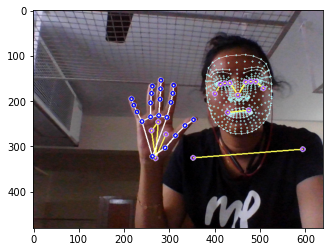

In [11]:
draw_styled_landmarks(frame, results) # apply landmarks
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) # color conversion

###### Extract Key-point Values

In [12]:
results.pose_landmarks

landmark {
  x: 0.707427442073822
  y: 0.3897028863430023
  z: -0.7594590187072754
  visibility: 0.9999574422836304
}
landmark {
  x: 0.733377993106842
  y: 0.3293289840221405
  z: -0.7225486040115356
  visibility: 0.9999093413352966
}
landmark {
  x: 0.751484751701355
  y: 0.32845646142959595
  z: -0.7225574254989624
  visibility: 0.9998999834060669
}
landmark {
  x: 0.76851886510849
  y: 0.3285561800003052
  z: -0.7225440144538879
  visibility: 0.9998893737792969
}
landmark {
  x: 0.678505003452301
  y: 0.33437955379486084
  z: -0.6951847076416016
  visibility: 0.9999232292175293
}
landmark {
  x: 0.6624462008476257
  y: 0.3370007872581482
  z: -0.6947081089019775
  visibility: 0.9999270439147949
}
landmark {
  x: 0.6461983919143677
  y: 0.34096306562423706
  z: -0.6946889162063599
  visibility: 0.9999357461929321
}
landmark {
  x: 0.7950430512428284
  y: 0.3594333827495575
  z: -0.4092045724391937
  visibility: 0.9998837113380432
}
landmark {
  x: 0.6275186538696289
  y: 0.384220242

In [13]:
def extract_keypoints(results):
    
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() \
    if results.pose_landmarks else np.zeros(33*4)
        
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() \
    if results.face_landmarks else np.zeros(468*3)
    
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() \
    if results.left_hand_landmarks else np.zeros(21*3)
    
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() \
    if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([pose, face, lh, rh])

In [14]:
extract_keypoints(results)

array([ 0.70742744,  0.38970289, -0.75945902, ...,  0.33943477,
        0.40801427, -0.03308184])

In [15]:
extract_keypoints(results).shape

(1662,)

In [16]:
data_path = os.path.join('MP_Data') #path for exported data

actions = np.array(['HELLO', 'THANKS', 'I LOVE U','YES','NO','PLEASE','GOOD BYE','SORRY','YOU ARE WELCOME','FAMILY','HOUSE','LOVE']) #actions to be detected

no_sequences = 10 #no. of videos collected for each action

sequence_length = 10 #frame length of each video

In [17]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(data_path, action, str(sequence)))
        except:
            pass

###### Collect Key-point Values for Train & Test

In [18]:
cap = cv2.VideoCapture(0) #to access webcam device

# set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    #NEW LOOP
    for action in actions: # loop through actions
        for sequence in range(no_sequences): # loop through sequences/videos
            for frame_no in range(sequence_length): # loop through video length 

                # read frames
                ret, frame = cap.read()

                # make detections
                image, results = mediapipe_detection(frame, holistic)

                # draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW collection wait logic
                if frame_no == 0:
                    cv2.putText(image, 'COLLECTING NOW...', (120, 200), 
                                cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for Action: {} & Video: {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image) # show image on screen
                    cv2.waitKey(1500) # 1.5 seconds break
                else:
                    cv2.putText(image, 'Collecting frames for Action: {} & Video: {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image) # show image on screen
                
                # NEW extract key-points
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_no))
                np.save(npy_path, keypoints)
                
                # break gracefully if hit 'q' on keyboard
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()           # release webcam
    cv2.destroyAllWindows() # close down all frames

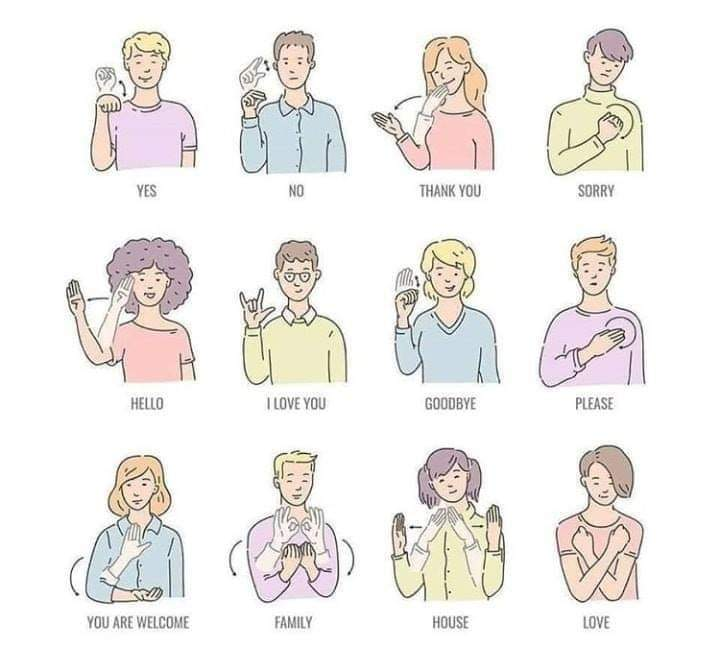

###### Pre-process Data and Create Lables & Features

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [20]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'HELLO': 0,
 'THANKS': 1,
 'I LOVE U': 2,
 'YES': 3,
 'NO': 4,
 'PLEASE': 5,
 'GOOD BYE': 6,
 'SORRY': 7,
 'YOU ARE WELCOME': 8,
 'FAMILY': 9,
 'HOUSE': 10,
 'LOVE': 11}

In [21]:
sequences, labels = [], [] # blank arrays
for action in actions:
    for sequence in range(no_sequences):
        window = [] # blank array
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [22]:
np.array(sequences).shape

(120, 10, 1662)

In [23]:
np.array(labels).shape

(120,)

In [24]:
X = np.array(sequences)
y = to_categorical(labels).astype(int) # one-hot-encoding

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

###### Build & Train LSTM Neural Network

In [26]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense 
from tensorflow.keras.callbacks import TensorBoard 

In [27]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [28]:
model = Sequential() 

# add 3 set of LSTM layers
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(10, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) 

# add 3 Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax')) # actions layer

In [29]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [30]:
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
4/4 [==============================] - 4s 51ms/step - loss: 2.5075 - categorical_accuracy: 0.0702
Epoch 2/1000
4/4 [==============================] - 0s 44ms/step - loss: 2.4712 - categorical_accuracy: 0.1579
Epoch 3/1000
4/4 [==============================] - 0s 46ms/step - loss: 2.4317 - categorical_accuracy: 0.1228
Epoch 4/1000
4/4 [==============================] - 0s 57ms/step - loss: 2.3807 - categorical_accuracy: 0.1404
Epoch 5/1000
4/4 [==============================] - 0s 66ms/step - loss: 2.2951 - categorical_accuracy: 0.1316
Epoch 6/1000
4/4 [==============================] - 0s 63ms/step - loss: 2.2828 - categorical_accuracy: 0.1491
Epoch 7/1000
4/4 [==============================] - 0s 48ms/step - loss: 2.2707 - categorical_accuracy: 0.1754
Epoch 8/1000
4/4 [==============================] - 0s 44ms/step - loss: 2.2779 - categorical_accuracy: 0.1667
Epoch 9/1000
4/4 [==============================] - 0s 56ms/step - loss: 2.1693 - categorical_accuracy: 0.1667
E

4/4 [==============================] - 0s 89ms/step - loss: 1.5082 - categorical_accuracy: 0.4035
Epoch 75/1000
4/4 [==============================] - 0s 84ms/step - loss: 1.4037 - categorical_accuracy: 0.4298
Epoch 76/1000
4/4 [==============================] - 0s 65ms/step - loss: 1.3170 - categorical_accuracy: 0.4649
Epoch 77/1000
4/4 [==============================] - 0s 79ms/step - loss: 1.2833 - categorical_accuracy: 0.4561
Epoch 78/1000
4/4 [==============================] - 0s 58ms/step - loss: 1.2868 - categorical_accuracy: 0.5088
Epoch 79/1000
4/4 [==============================] - 0s 42ms/step - loss: 1.2120 - categorical_accuracy: 0.5175
Epoch 80/1000
4/4 [==============================] - 0s 85ms/step - loss: 1.4288 - categorical_accuracy: 0.4211
Epoch 81/1000
4/4 [==============================] - 0s 49ms/step - loss: 1.1510 - categorical_accuracy: 0.5877
Epoch 82/1000
4/4 [==============================] - 0s 48ms/step - loss: 1.2973 - categorical_accuracy: 0.5614
Epoch 

4/4 [==============================] - 0s 55ms/step - loss: 0.5747 - categorical_accuracy: 0.7632
Epoch 147/1000
4/4 [==============================] - 0s 44ms/step - loss: 0.6516 - categorical_accuracy: 0.7807
Epoch 148/1000
4/4 [==============================] - 0s 71ms/step - loss: 0.6503 - categorical_accuracy: 0.7456
Epoch 149/1000
4/4 [==============================] - 0s 75ms/step - loss: 0.5883 - categorical_accuracy: 0.7807
Epoch 150/1000
4/4 [==============================] - 0s 68ms/step - loss: 0.5991 - categorical_accuracy: 0.7281
Epoch 151/1000
4/4 [==============================] - 0s 67ms/step - loss: 0.8118 - categorical_accuracy: 0.6316
Epoch 152/1000
4/4 [==============================] - 0s 70ms/step - loss: 0.6326 - categorical_accuracy: 0.7281
Epoch 153/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.7317 - categorical_accuracy: 0.6930
Epoch 154/1000
4/4 [==============================] - 0s 70ms/step - loss: 0.6379 - categorical_accuracy: 0.754

4/4 [==============================] - 0s 67ms/step - loss: 0.8681 - categorical_accuracy: 0.6930
Epoch 219/1000
4/4 [==============================] - 0s 66ms/step - loss: 0.9988 - categorical_accuracy: 0.6930
Epoch 220/1000
4/4 [==============================] - 0s 71ms/step - loss: 1.0376 - categorical_accuracy: 0.7368
Epoch 221/1000
4/4 [==============================] - 0s 77ms/step - loss: 0.8509 - categorical_accuracy: 0.7281
Epoch 222/1000
4/4 [==============================] - 0s 65ms/step - loss: 0.6248 - categorical_accuracy: 0.7719
Epoch 223/1000
4/4 [==============================] - 0s 68ms/step - loss: 0.5702 - categorical_accuracy: 0.8070
Epoch 224/1000
4/4 [==============================] - 0s 54ms/step - loss: 0.5030 - categorical_accuracy: 0.8246
Epoch 225/1000
4/4 [==============================] - 0s 68ms/step - loss: 0.4863 - categorical_accuracy: 0.8596
Epoch 226/1000
4/4 [==============================] - 0s 63ms/step - loss: 0.5068 - categorical_accuracy: 0.789

4/4 [==============================] - 0s 74ms/step - loss: 0.2492 - categorical_accuracy: 0.9211
Epoch 291/1000
4/4 [==============================] - 0s 56ms/step - loss: 0.2810 - categorical_accuracy: 0.8947
Epoch 292/1000
4/4 [==============================] - 0s 43ms/step - loss: 0.2466 - categorical_accuracy: 0.9298
Epoch 293/1000
4/4 [==============================] - 0s 42ms/step - loss: 0.2376 - categorical_accuracy: 0.9474
Epoch 294/1000
4/4 [==============================] - 0s 49ms/step - loss: 0.2969 - categorical_accuracy: 0.8772
Epoch 295/1000
4/4 [==============================] - 0s 46ms/step - loss: 0.2455 - categorical_accuracy: 0.9123
Epoch 296/1000
4/4 [==============================] - 0s 55ms/step - loss: 0.2098 - categorical_accuracy: 0.9123
Epoch 297/1000
4/4 [==============================] - 0s 59ms/step - loss: 0.3510 - categorical_accuracy: 0.8684
Epoch 298/1000
4/4 [==============================] - 0s 48ms/step - loss: 0.2929 - categorical_accuracy: 0.903

4/4 [==============================] - 0s 44ms/step - loss: 0.1600 - categorical_accuracy: 0.9649
Epoch 363/1000
4/4 [==============================] - 0s 42ms/step - loss: 0.1791 - categorical_accuracy: 0.9474
Epoch 364/1000
4/4 [==============================] - 0s 45ms/step - loss: 0.1376 - categorical_accuracy: 0.9561
Epoch 365/1000
4/4 [==============================] - 0s 42ms/step - loss: 0.1447 - categorical_accuracy: 0.9649
Epoch 366/1000
4/4 [==============================] - 0s 43ms/step - loss: 0.1340 - categorical_accuracy: 0.9561
Epoch 367/1000
4/4 [==============================] - 0s 44ms/step - loss: 0.1498 - categorical_accuracy: 0.9386
Epoch 368/1000
4/4 [==============================] - 0s 45ms/step - loss: 0.1384 - categorical_accuracy: 0.9649
Epoch 369/1000
4/4 [==============================] - 0s 45ms/step - loss: 0.1840 - categorical_accuracy: 0.9386
Epoch 370/1000
4/4 [==============================] - 0s 41ms/step - loss: 0.1692 - categorical_accuracy: 0.921

4/4 [==============================] - 0s 45ms/step - loss: 0.1571 - categorical_accuracy: 0.9386
Epoch 435/1000
4/4 [==============================] - 0s 47ms/step - loss: 0.1515 - categorical_accuracy: 0.9386
Epoch 436/1000
4/4 [==============================] - 0s 33ms/step - loss: 0.1649 - categorical_accuracy: 0.9386
Epoch 437/1000
4/4 [==============================] - 0s 33ms/step - loss: 0.2269 - categorical_accuracy: 0.9123
Epoch 438/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.1234 - categorical_accuracy: 0.9912
Epoch 439/1000
4/4 [==============================] - 0s 46ms/step - loss: 0.1379 - categorical_accuracy: 0.9386
Epoch 440/1000
4/4 [==============================] - 0s 44ms/step - loss: 0.1571 - categorical_accuracy: 0.9386
Epoch 441/1000
4/4 [==============================] - 0s 46ms/step - loss: 0.1897 - categorical_accuracy: 0.9386
Epoch 442/1000
4/4 [==============================] - 0s 42ms/step - loss: 0.1483 - categorical_accuracy: 0.947

4/4 [==============================] - 0s 41ms/step - loss: 0.1484 - categorical_accuracy: 0.9649
Epoch 507/1000
4/4 [==============================] - 0s 38ms/step - loss: 0.1176 - categorical_accuracy: 0.9737
Epoch 508/1000
4/4 [==============================] - 0s 40ms/step - loss: 0.1122 - categorical_accuracy: 0.9737
Epoch 509/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.1303 - categorical_accuracy: 0.9474
Epoch 510/1000
4/4 [==============================] - 0s 39ms/step - loss: 0.1266 - categorical_accuracy: 0.9386
Epoch 511/1000
4/4 [==============================] - 0s 41ms/step - loss: 0.0964 - categorical_accuracy: 0.9649
Epoch 512/1000
4/4 [==============================] - 0s 41ms/step - loss: 0.1413 - categorical_accuracy: 0.9474
Epoch 513/1000
4/4 [==============================] - 0s 38ms/step - loss: 0.1121 - categorical_accuracy: 0.9737
Epoch 514/1000
4/4 [==============================] - 0s 38ms/step - loss: 0.1061 - categorical_accuracy: 0.964

4/4 [==============================] - 0s 46ms/step - loss: 0.2164 - categorical_accuracy: 0.9123
Epoch 579/1000
4/4 [==============================] - 0s 41ms/step - loss: 0.2633 - categorical_accuracy: 0.8947
Epoch 580/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.2214 - categorical_accuracy: 0.9123
Epoch 581/1000
4/4 [==============================] - 0s 41ms/step - loss: 0.1931 - categorical_accuracy: 0.9211
Epoch 582/1000
4/4 [==============================] - 0s 43ms/step - loss: 0.1240 - categorical_accuracy: 0.9737
Epoch 583/1000
4/4 [==============================] - 0s 41ms/step - loss: 0.1039 - categorical_accuracy: 0.9561
Epoch 584/1000
4/4 [==============================] - 0s 43ms/step - loss: 0.1441 - categorical_accuracy: 0.9211
Epoch 585/1000
4/4 [==============================] - 0s 39ms/step - loss: 0.1684 - categorical_accuracy: 0.9298
Epoch 586/1000
4/4 [==============================] - 0s 39ms/step - loss: 0.1287 - categorical_accuracy: 0.947

4/4 [==============================] - 0s 75ms/step - loss: 0.1448 - categorical_accuracy: 0.9474
Epoch 651/1000
4/4 [==============================] - 0s 61ms/step - loss: 0.1026 - categorical_accuracy: 0.9649
Epoch 652/1000
4/4 [==============================] - 0s 62ms/step - loss: 0.0998 - categorical_accuracy: 0.9737
Epoch 653/1000
4/4 [==============================] - 0s 66ms/step - loss: 0.0789 - categorical_accuracy: 0.9825
Epoch 654/1000
4/4 [==============================] - 0s 78ms/step - loss: 0.0707 - categorical_accuracy: 0.9737
Epoch 655/1000
4/4 [==============================] - 0s 114ms/step - loss: 0.0941 - categorical_accuracy: 0.9561
Epoch 656/1000
4/4 [==============================] - 0s 71ms/step - loss: 0.0935 - categorical_accuracy: 0.9737
Epoch 657/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.0780 - categorical_accuracy: 0.9737
Epoch 658/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.0752 - categorical_accuracy: 0.97

4/4 [==============================] - 0s 47ms/step - loss: 0.2885 - categorical_accuracy: 0.8947
Epoch 723/1000
4/4 [==============================] - 0s 48ms/step - loss: 0.2199 - categorical_accuracy: 0.9035
Epoch 724/1000
4/4 [==============================] - 0s 46ms/step - loss: 0.1958 - categorical_accuracy: 0.9386
Epoch 725/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.1544 - categorical_accuracy: 0.9561
Epoch 726/1000
4/4 [==============================] - 0s 45ms/step - loss: 0.1256 - categorical_accuracy: 0.9737
Epoch 727/1000
4/4 [==============================] - 0s 46ms/step - loss: 0.1283 - categorical_accuracy: 0.9649
Epoch 728/1000
4/4 [==============================] - 0s 46ms/step - loss: 0.1149 - categorical_accuracy: 0.9649
Epoch 729/1000
4/4 [==============================] - 0s 44ms/step - loss: 0.1273 - categorical_accuracy: 0.9474
Epoch 730/1000
4/4 [==============================] - 0s 40ms/step - loss: 0.1330 - categorical_accuracy: 0.947

4/4 [==============================] - 0s 42ms/step - loss: 0.1913 - categorical_accuracy: 0.9386
Epoch 795/1000
4/4 [==============================] - 0s 44ms/step - loss: 0.1814 - categorical_accuracy: 0.9561
Epoch 796/1000
4/4 [==============================] - 0s 39ms/step - loss: 0.1535 - categorical_accuracy: 0.9386
Epoch 797/1000
4/4 [==============================] - 0s 57ms/step - loss: 0.1544 - categorical_accuracy: 0.9298
Epoch 798/1000
4/4 [==============================] - 0s 79ms/step - loss: 0.1580 - categorical_accuracy: 0.9386
Epoch 799/1000
4/4 [==============================] - 0s 47ms/step - loss: 0.0936 - categorical_accuracy: 0.9737
Epoch 800/1000
4/4 [==============================] - 0s 52ms/step - loss: 0.1003 - categorical_accuracy: 0.9649
Epoch 801/1000
4/4 [==============================] - 0s 41ms/step - loss: 0.0992 - categorical_accuracy: 0.9561
Epoch 802/1000
4/4 [==============================] - 0s 45ms/step - loss: 0.0749 - categorical_accuracy: 0.982

4/4 [==============================] - 0s 47ms/step - loss: 0.0329 - categorical_accuracy: 0.9912
Epoch 867/1000
4/4 [==============================] - 0s 48ms/step - loss: 0.0234 - categorical_accuracy: 0.9912
Epoch 868/1000
4/4 [==============================] - 0s 46ms/step - loss: 0.0641 - categorical_accuracy: 0.9825
Epoch 869/1000
4/4 [==============================] - 0s 45ms/step - loss: 0.1213 - categorical_accuracy: 0.9474
Epoch 870/1000
4/4 [==============================] - 0s 41ms/step - loss: 0.0577 - categorical_accuracy: 0.9737
Epoch 871/1000
4/4 [==============================] - 0s 41ms/step - loss: 0.0543 - categorical_accuracy: 0.9737
Epoch 872/1000
4/4 [==============================] - 0s 47ms/step - loss: 0.0844 - categorical_accuracy: 0.9737
Epoch 873/1000
4/4 [==============================] - 0s 46ms/step - loss: 0.1349 - categorical_accuracy: 0.9211
Epoch 874/1000
4/4 [==============================] - 0s 44ms/step - loss: 0.0945 - categorical_accuracy: 0.964

4/4 [==============================] - 0s 69ms/step - loss: 0.1514 - categorical_accuracy: 0.9561
Epoch 939/1000
4/4 [==============================] - 0s 58ms/step - loss: 0.0951 - categorical_accuracy: 0.9737
Epoch 940/1000
4/4 [==============================] - 0s 64ms/step - loss: 0.0660 - categorical_accuracy: 0.9825
Epoch 941/1000
4/4 [==============================] - 0s 56ms/step - loss: 0.0685 - categorical_accuracy: 0.9825
Epoch 942/1000
4/4 [==============================] - 0s 47ms/step - loss: 0.0710 - categorical_accuracy: 0.9649
Epoch 943/1000
4/4 [==============================] - 0s 46ms/step - loss: 0.0570 - categorical_accuracy: 0.9825
Epoch 944/1000
4/4 [==============================] - 0s 47ms/step - loss: 0.0534 - categorical_accuracy: 0.9737
Epoch 945/1000
4/4 [==============================] - 0s 58ms/step - loss: 0.0462 - categorical_accuracy: 0.9825
Epoch 946/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.0399 - categorical_accuracy: 0.991

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 12)                396       
                                                                 
Total params: 596972 (2.28 MB)
Trainable params: 596972 

###### Make Predictions

In [32]:
res = model.predict(X_test)#Now, we will make the predictions on the test data based on this model.

1/1 [==============================] - 0s 372ms/step


In [33]:
actions[np.argmax(res[2])]#We can check the prediction for a random action by unpacking the results

'THANKS'

In [34]:
actions[np.argmax(y_test[2])]

'THANKS'

In [37]:
model.save('fin_mod.h5')

In [38]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [39]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 24ms/step


In [40]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
multilabel_confusion_matrix(ytrue, yhat)

array([[[5, 0],
        [0, 1]],

       [[5, 0],
        [0, 1]],

       [[5, 0],
        [0, 1]],

       [[5, 0],
        [0, 1]],

       [[5, 0],
        [1, 0]],

       [[5, 1],
        [0, 0]],

       [[5, 0],
        [0, 1]]], dtype=int64)

In [41]:
accuracy_score(ytrue, yhat)

0.8333333333333334

In [42]:
yhat_t = model.predict(X_train)
ytrue_t = np.argmax(y_train, axis=1).tolist()
yhat_t = np.argmax(yhat_t, axis=1).tolist()
multilabel_confusion_matrix(ytrue_t, yhat_t)

4/4 [==============================] - 0s 10ms/step


array([[[105,   0],
        [  0,   9]],

       [[105,   0],
        [  0,   9]],

       [[104,   0],
        [  0,  10]],

       [[104,   0],
        [  0,  10]],

       [[104,   0],
        [  0,  10]],

       [[104,   0],
        [  0,  10]],

       [[105,   0],
        [  0,   9]],

       [[105,   0],
        [  2,   7]],

       [[103,   2],
        [  0,   9]],

       [[104,   0],
        [  0,  10]],

       [[104,   0],
        [  0,  10]],

       [[105,   0],
        [  0,   9]]], dtype=int64)

In [43]:
accuracy_score(ytrue_t, yhat_t)

0.9824561403508771

###### Real-time Testing

In [44]:
# render probabilites
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (255,0,0), (255,153,0),(255,255,0),(128,0,128),(0,255,255),(128,0,0),(127,255,212),(75,0,130),(250,0,0)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*35), (int(prob*100), 90+num*35), colors[num], -1) # drawing a dynamic rectangle
        cv2.putText(output_frame, actions[num], (0, 85+num*35), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1, cv2.LINE_AA)
    return output_frame

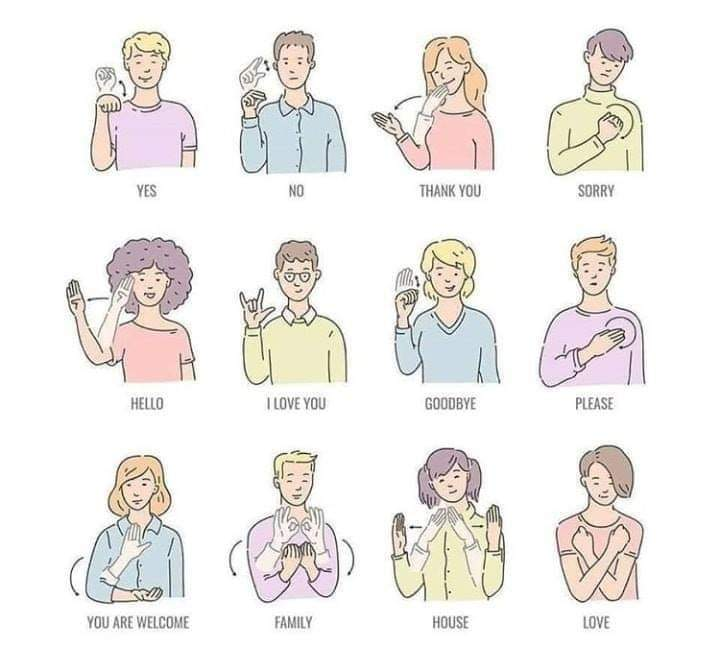

In [45]:
#1. new detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7

cap = cv2.VideoCapture(0) #to access webcam device

# set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():     # loop through all frames

        # read frames
        ret, frame = cap.read()

        # make detections
        image, results = mediapipe_detection(frame, holistic)
       
        # draw formatted landmarks
        draw_styled_landmarks(image, results)        
#-------------------------------------------------------------------------
        #2. prediction logic
        keypoints = extract_keypoints(results) # extracting the keypoints
        sequence.append(keypoints)
        sequence = sequence[-10:] #grab last 10 frames
        
        if len(sequence) == 10:
            res = model.predict(np.expand_dims(sequence, axis=0))[0] 
#            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))            
#-------------------------------------------------------------------------
        #3. visualisation logic
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                
                if res[np.argmax(res)] > threshold:
                
                    if len(sentence) > 0: #check for words in sentence
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
                        
            if len(sentence) > 8:
                sentence = sentence[-8:]
#---------------------q----------------------------------------------------                
            #4. visualization probabilites
            image = prob_viz(res, actions, image, colors)
#-------------------------------q------------------------------------------

        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2, cv2.LINE_AA)
                               
        # show image on screen
        cv2.imshow('OpenCV Feed',cv2.resize(image,(600,500)))

        # break gracefully if hit 'q' on keyboard
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()           # release webcam
    cv2.destroyAllWindows() # close down all frames

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step
